# Detección de fraude
---
Esta parte de la evaluación consiste en realizar un modelo de predicción de fraude.

El set de datos està en `data/fraud/creditcard_train.csv`

La evaluación es tipo *datathon* de forma que las notas se calcularán en base a:

1. Al ranking de métricas de los modelos (80%)
2. Legibilidad y presentación del código (20%)

La forma de entrega será generar un fichero csv en formato a partir de las predicciones realizadas sobre el fichero `data/fraud/creditcard_test.csv`.

| IdObservación | clase_predicha | probabilidad_clase_1 |
| ------------- | ------------- | ------------- |
|00001|True|0.6398|
|00002|True|0.5892|
|00003|False|0.2163|

EL fichero resultante tiene que tener por nombre `inicialapellido_test.csv` y se tiene que enviar por email a:

datathonuib@gmail.com

<br>

<div class='panel panel-success'>
    <div class='panel-heading'>
        <h2>Índice</h2>
    </div>
    <div class='panel-body'>
        <ol type="A">
            <li><a href=#carga>Carga de datos</a></li>
            <li><a href=#exploracion>Exploración de datos</a></li>
            <li><a href=#separacion>Separación de datos de entrenamiento y prueba</a></li>
            <li><a href=#knn>K-Nearest Neighbors Classifier</a></li>
            <li><a href=#regresion-logistica>Regresión logística</a></li>
            <li><a href=#arbol-decision>Árboles de decisión</a></li>
                <ol type=B>
                    <li><a href=#arbol-decision-basico>Árbol de decisión básico</a></li>
                    <li><a href=#arbol-decision-gs>Árbol de decisión mediante GridSearchCV</a></li>
                    <li><a href=#arbol-decision-visualizacion>Visualización de las variables más importantes</a></li>
                    <li><a href=#arbol-decision-final>Visualización del árbol final</a></li>
                </ol>
            <li><a href=#random-forest>Random Forest</a></li>
                <ol type=B>
                   <li><a href=#random-forest-visualizacion>Visualización de las variables más importantes</a></li>
                </ol>
           <li><a href=#resampling>Resampling</a></li>
                <ol type=B>
                   <li><a href=#downsampling>Downsampling</a></li>
                   <li><a href=#upsampling>Upsampling</a></li>
                   <li><a href=#negative-downsampling>Negative downsampling</a></li>
                </ol>
           <li><a href=#verificacion-1>Verificación del test final con Upsampling (Modelo 1)</a></li>
           <li><a href=#verificacion-2>Verificación del test final con Calibrating (Modelo 2)</a></li>
           <li><a href=#bibliografia>Bibliografía</a></li>
        </ol>
    </div>
</div>

# 1. Carga de datos <a class="anchor" id="carga"></a>

In [1]:
import os
import glob
import math

import pandas as pd
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 80)

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

import seaborn as sns

from sklearn.metrics import roc_auc_score, confusion_matrix, log_loss, brier_score_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('data/fraud/creditcard_train.csv', index_col=0, sep=',')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,44.0,-0.948896,0.248414,2.956914,2.813750,0.145539,-0.027353,0.133702,-0.307535,-0.125244,1.034940,-0.532648,-0.189878,0.081222,-0.939053,0.081187,-0.129785,-0.174353,-0.090291,0.222435,-0.056186,-0.083647,0.416090,0.207537,0.716064,-0.602311,-0.064230,-0.315058,-0.272463,0.75,0
1,56.0,0.086996,-0.051989,-0.497882,-3.151908,2.558400,2.796671,0.470283,0.265333,0.919513,-0.735586,0.208725,0.017131,-0.110867,-0.042677,1.654140,-0.392648,-0.875960,0.183946,1.259380,0.167231,-0.239426,-0.437342,0.018426,1.013038,-0.258927,-0.293189,-0.394956,-0.435996,10.84,0
2,125.0,-0.724910,0.073475,1.739547,0.758588,0.229543,2.422069,0.196688,0.861076,0.099102,-0.730405,1.327101,1.005463,-0.987890,-0.090716,-0.711233,-1.635743,1.150431,-1.610390,-1.044671,-0.044215,0.188696,0.738515,0.145933,-1.032186,-0.087511,-0.221063,0.108168,0.011785,113.00,0
3,140.0,1.175478,0.167881,0.509909,0.452332,-0.215763,-0.192104,-0.105404,0.068517,-0.249733,0.053143,1.737927,1.253325,0.419215,0.422534,0.560529,0.197462,-0.407985,-0.520951,-0.188320,-0.101554,-0.176147,-0.500566,0.151263,0.018347,0.122003,0.106307,-0.014937,0.005771,1.29,0
4,196.0,1.198658,-0.420334,0.014599,-0.270793,-0.471074,-0.384610,-0.083890,-0.077570,-1.537508,0.846368,1.512576,0.858693,0.410550,0.529565,0.147448,-1.573951,0.024288,0.499010,-0.739676,-0.401552,-0.630206,-1.504432,0.193771,-0.017458,0.058387,0.145373,-0.034904,0.011037,63.90,0


In [3]:
df.shape

(8274, 31)

In [4]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

# 2. Exploración de los datos <a class="anchor" id="exploracion"></a>

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000
mean,94413.335630,-0.192386,0.164128,-0.320883,0.214420,-0.138538,-0.045972,-0.260026,0.020558,-0.101755,-0.269548,0.158620,-0.288611,-0.013928,-0.309883,-0.010528,-0.199374,-0.295515,-0.113165,0.037922,0.029138,0.036519,-0.010749,0.005431,-0.010122,0.011992,0.008631,0.010403,0.002055,89.591424,0.047619
std,47090.203021,2.539145,1.976724,2.536887,1.758363,1.861499,1.380380,2.269845,1.890984,1.307423,1.912744,1.382912,1.895243,1.005914,1.925050,0.932342,1.452949,2.195492,1.130513,0.866818,0.744955,1.134010,0.786006,0.601718,0.598658,0.521701,0.487096,0.471975,0.311344,239.425840,0.212972
min,44.000000,-30.552380,-34.575064,-31.103685,-5.020488,-25.025820,-9.847370,-43.557242,-41.044261,-13.434066,-24.588262,-3.031459,-18.683715,-3.816448,-19.214325,-4.498945,-13.303888,-25.162799,-9.498746,-3.681904,-12.039683,-22.797604,-8.887017,-15.981649,-2.766638,-3.536716,-1.480189,-7.263482,-5.706918,0.000000,0.000000
25%,54238.500000,-0.989676,-0.583268,-1.090674,-0.780131,-0.749119,-0.803048,-0.623201,-0.201921,-0.694891,-0.617561,-0.735958,-0.503086,-0.674686,-0.514018,-0.578520,-0.531628,-0.519847,-0.553018,-0.449117,-0.206675,-0.231617,-0.550772,-0.163394,-0.362282,-0.311030,-0.321798,-0.068158,-0.054186,5.000000,0.000000
50%,84863.500000,-0.023586,0.114158,0.106146,0.063112,-0.070332,-0.292343,0.011035,0.032206,-0.073247,-0.146724,0.009305,0.101333,-0.021888,0.012903,0.042378,0.019582,-0.081863,-0.034217,0.030674,-0.054189,-0.022282,0.001268,-0.011584,0.031144,0.031149,-0.044219,0.005249,0.013256,21.230000,0.000000
75%,138697.500000,1.297560,0.888651,0.974192,0.882648,0.598011,0.408838,0.550909,0.358243,0.585619,0.391222,0.822606,0.590213,0.651375,0.471503,0.644728,0.499536,0.399405,0.474696,0.484616,0.155766,0.206964,0.521199,0.145209,0.422574,0.358695,0.264279,0.108512,0.084301,78.900000,0.000000
max,172786.000000,2.371289,22.057729,4.187811,12.114672,16.625394,14.570654,26.237722,20.007208,6.778615,10.664992,12.018913,3.379534,4.262851,4.873405,3.010598,3.502924,6.739384,3.832712,5.228342,16.436920,27.202839,8.361985,17.606637,3.633399,3.410742,2.807408,4.347262,9.641075,7541.700000,1.000000


Comprobamos si existen valores a nulo:

In [6]:
df.isnull().any().any()

False

Miramos cuántos valores hay por cada clase a predecir:

In [7]:
df.Class.value_counts()

0    7880
1     394
Name: Class, dtype: int64

Las clases están desbalanceadas, habiendo alrededor de un 5% de los datos para la clase 1. Por lo tanto, habrá que aplicar métodos para rebalancear las clases [[1](https://medium.com/bluekiri/dealing-with-highly-imbalanced-classes-7e36330250bc)] como, por ejemplo:

* **Downsampling**: todas las observaciones de la clase minoritaría se mantienen, mientras que se rebalancea la clase mayoritaria (sin reemplazo) haciendo que el número de observaciones resultantes sea igual al tamaño de la clase minoritaria.

* **Upsampling**: se duplica aleatoriamente el número de muestras de la clase minoritaria para que sea igual al número de muestras de la clase mayoritaria y así reforzar su señal.

* **Negative downsampling**: se usan diferentes tamaños de muestras, dejando igual al número de muestras de la clase minoritaria y cogiendo diferentes números de observaciones de la clase mayoritaria (sin reemplazo).

A continuación, comprobamos la correlación entre la variable a predecir y las demás variables:

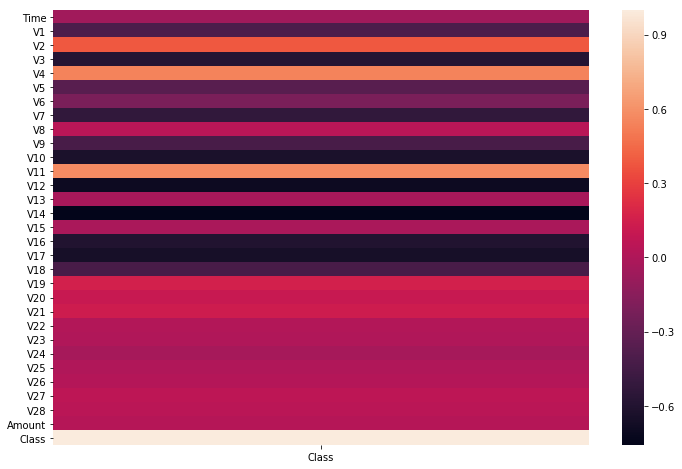

In [8]:
sns.heatmap(df.corr()[['Class']])

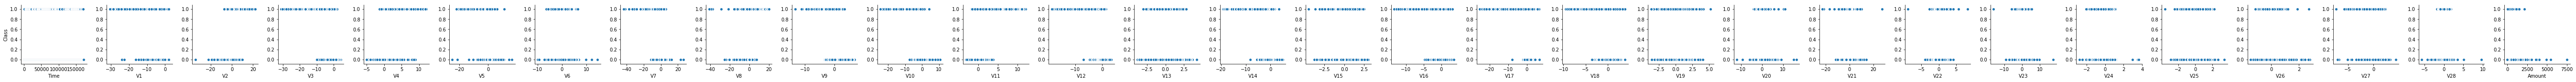

In [9]:
features = df.loc[:, df.columns != 'Class'].columns

sns.pairplot(df, y_vars=['Class'], x_vars=features)

# 3. Separación de datos de entrenamiento y prueba <a class="anchor" id="separacion"></a>

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
df_X = df.copy()
df_y = df_X['Class']
del df_X['Class']

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, 
                                                    test_size = 0.25, 
                                                    random_state = 1234)

In [12]:
print("X_train: " + str(X_train.shape))
print("X_test:  " + str(X_test.shape))
print("y_train: " + str(y_train.shape))
print("y_test:  " + str(y_test.shape))

X_train: (6205, 30)
X_test:  (2069, 30)
y_train: (6205,)
y_test:  (2069,)


In [13]:
y_train.value_counts()

0    5924
1     281
Name: Class, dtype: int64

In [14]:
y_test.value_counts()

0    1956
1     113
Name: Class, dtype: int64

# 4. K-Nearest Neighbors Classifier <a class="anchor" id="knn"></a>

In [15]:
from sklearn.neighbors import KNeighborsClassifier

In [16]:
scaler = StandardScaler()
knn_class = KNeighborsClassifier()

scaler_step = ('scaler', scaler)
knn_class_step = ('knn', knn_class)
steps = [scaler_step, knn_class_step]
pipe = Pipeline(steps)

params = {'knn__n_neighbors': range(2, 10),
          'knn__weights': ['uniform', 'distance'],
          'knn__algorithm': ['auto', 'kd_tree'],
          'knn__p': [1, 2]} # distance metric

kfold = StratifiedKFold(n_splits = 5)

gs_knn_class = GridSearchCV(pipe, param_grid=params, cv=kfold, n_jobs=-1)
gs_knn_class.fit(X_train, y_train)

y_pred_gs_knn_class = gs_knn_class.predict(X_test)
y_pred_gs_knn_class_proba = gs_knn_class.predict_proba(X_test)

print("Best params: ", gs_knn_class.best_params_)
print('\n')
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_gs_knn_class_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_gs_knn_class, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_gs_knn_class))
print("Precision:", precision_score(y_test, y_pred_gs_knn_class))
print("Recall:", recall_score(y_test, y_pred_gs_knn_class))
print("F1:", f1_score(y_test, y_pred_gs_knn_class))

Best params:  {'knn__n_neighbors': 5, 'knn__weights': 'uniform', 'knn__p': 1, 'knn__algorithm': 'auto'}


ROC Curve: 0.93


Confusion matrix: 
 [[  94   19]
 [   1 1955]]


Accuracy: 0.990333494442
Precision: 0.989473684211
Recall: 0.83185840708
F1: 0.903846153846


# 5. Regresión logística <a class="anchor" id="regresion-logistica"></a>

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
scaler = StandardScaler()
class_LR = LogisticRegression()

scaler_step = ('scaler', scaler)
class_LR_step = ('class_LR', class_LR)
steps = [scaler_step, class_LR_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)

y_pred_LR = pipe.predict(X_test)
y_pred_LR_proba = pipe.predict_proba(X_test)

print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_LR_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_LR, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_LR))
print("Precision:", precision_score(y_test, y_pred_LR))
print("Recall:", recall_score(y_test, y_pred_LR))
print("F1:", f1_score(y_test, y_pred_LR))
print('\n')
print("Log loss:", log_loss(y_test, y_pred_LR_proba[:, 1]))

ROC Curve: 0.97


Confusion matrix: 
 [[  95   18]
 [   1 1955]]


Accuracy: 0.99081681972
Precision: 0.989583333333
Recall: 0.840707964602
F1: 0.909090909091


Log loss: 0.0441987943402


# 6. Árbol de decisión <a class="anchor" id="arbol-decision"></a>

In [19]:
from sklearn.tree import DecisionTreeClassifier

### 6.1 Árbol de decisión básico <a class="anchor" id="arbol-decision-basico"></a>

Creamos un modelo con un árbol de decisión sin modificar ningún parámetro:

In [20]:
scaler = StandardScaler()
class_DT = DecisionTreeClassifier()

scaler_step = ('scaler', scaler)
class_DT_step = ('class_DT', class_DT)
steps = [scaler_step, class_DT_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)

y_pred_class_DT = pipe.predict(X_test)
y_pred_class_DT_proba = pipe.predict_proba(X_test)

print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_class_DT_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_class_DT, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_class_DT))
print("Precision:", precision_score(y_test, y_pred_class_DT))
print("Recall:", recall_score(y_test, y_pred_class_DT))
print("F1:", f1_score(y_test, y_pred_class_DT))

ROC Curve: 0.91


Confusion matrix: 
 [[  95   18]
 [  23 1933]]


Accuracy: 0.980183663606
Precision: 0.805084745763
Recall: 0.840707964602
F1: 0.822510822511


### 6.2 Árbol de decisión mediante GridSearchCV <a class="anchor" id="arbol-decision-gs"></a>

Para ver si mejora un modelo basado en árboles de decisión, utilizamos la función de **GridSearchCV** para modificar los parámetros.

In [21]:
scaler = StandardScaler()
class_DT = DecisionTreeClassifier()

scaler_step = ('scaler', scaler)
class_DT_step = ('class_DT', class_DT)

steps = [scaler_step, class_DT_step]

pipe = Pipeline(steps)

params = {'class_DT__max_depth': range(1, 8),
          'class_DT__min_samples_split': range(2, 10),
          'class_DT__min_samples_leaf': range(2, 10),
          'class_DT__criterion': ['gini', 'entropy']}

kfold = StratifiedKFold(n_splits = 5)

gs_class_DT = GridSearchCV(pipe, param_grid=params, cv=kfold, n_jobs=-1)
gs_class_DT.fit(X_train, y_train)

y_pred_gs_class_DT = gs_class_DT.predict(X_test)
y_pred_gs_class_DT_proba = gs_class_DT.predict_proba(X_test)

print("Best params: ", gs_class_DT.best_params_)
print('\n')
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_gs_class_DT_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_gs_class_DT, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_gs_class_DT))
print("Precision:", precision_score(y_test, y_pred_gs_class_DT))
print("Recall:", recall_score(y_test, y_pred_gs_class_DT))
print("F1:", f1_score(y_test, y_pred_gs_class_DT))

Best params:  {'class_DT__max_depth': 3, 'class_DT__criterion': 'entropy', 'class_DT__min_samples_leaf': 2, 'class_DT__min_samples_split': 2}


ROC Curve: 0.95


Confusion matrix: 
 [[  94   19]
 [   3 1953]]


Accuracy: 0.989366843886
Precision: 0.969072164948
Recall: 0.83185840708
F1: 0.895238095238


Observamos que la métrica ROC Curve ha pasado de un 0.92 a un 0.95, usando una profundidad de 3, lo que quiere decir que usa pocas variables para crear el árbol.

### 6.3 Visualización de las variables más importantes <a class="anchor" id="arbol-decision-visualizacion"></a>

In [22]:
class_DT = DecisionTreeClassifier(max_depth = gs_class_DT.best_params_['class_DT__max_depth'],
                                  min_samples_leaf = gs_class_DT.best_params_['class_DT__min_samples_leaf'],
                                  min_samples_split = gs_class_DT.best_params_['class_DT__min_samples_split'],
                                  criterion = gs_class_DT.best_params_['class_DT__criterion'])
class_DT.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

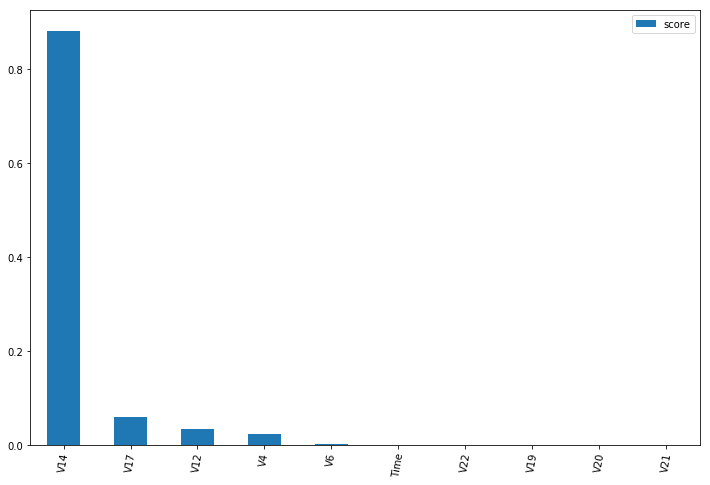

In [23]:
feat = pd.DataFrame(index=X_train.keys(), data=class_DT.feature_importances_, columns=['score'])
feat = feat.sort_values(by='score', ascending=False)

feat[:10].plot(kind='bar', rot=80)

Como hemos dicho anteriormente, este modelo usa pocas variables para crear el árbol. En concreto usa 5, teniendo como la más importante **V14**.

### 6.4 Visualización del árbol final <a class="anchor" id="arbol-decision-final"></a>

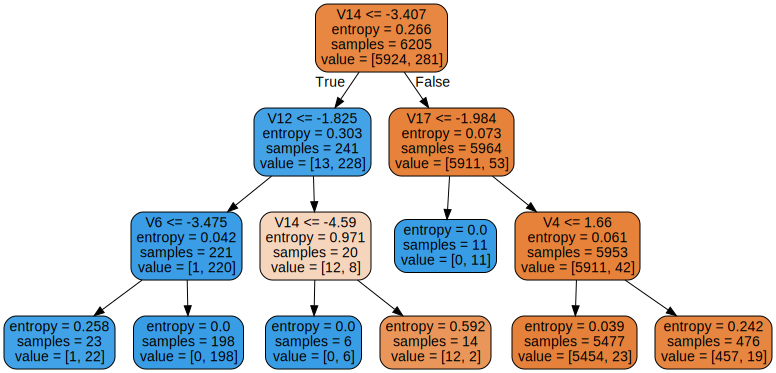

In [24]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(class_DT, 
                                  out_file=None, 
                                  feature_names=X_train.columns,
                                  filled=True,
                                  rounded=True)
graphviz.Source(tree_graph)

# 7. Random Forest <a class="anchor" id="random-forest"></a>

In [25]:
from sklearn.ensemble import RandomForestClassifier

**Random Forest** provee una mejora sobre los árboles de decisión para reducir la varianza. Esto se hace de modo que cada vez que se hace una división en un árbol, se considera una selección aleatoria de m predictores elegidos como candidatos de división de todo el conjunto de p predictores.

Normalmente se usa $m = \sqrt{p}$, lo cual se refleja en el siguiente algoritmo mediante el parámetro *max_features = 'sqrt'*, aunque también se busca si con *max_features = 'auto'*, que es $m = p$ mejora el resultado. Además, con el parámetro n_estimators indicamos el número de árboles que se generan y con max_depth la profundidad de cada árbol. Estimamos la mejor combinación de estos parámetros mediante **GridSearchCV**.

In [26]:
scaler = StandardScaler()
rand_for_class = RandomForestClassifier()

scaler_step = ('scaler', scaler)
rand_for_class_step = ('rand_for_class', rand_for_class)
steps = [scaler_step, rand_for_class_step]
pipe = Pipeline(steps)

tuned_parameters = {'rand_for_class__n_estimators': range(15, 30, 2),
                    'rand_for_class__max_features': ['sqrt', 'auto'],
                    'rand_for_class__max_depth': range(8, 25)}

kfold = StratifiedKFold(n_splits = 5)

gs_rand_for_class = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_rand_for_class.fit(X_train, y_train)

y_pred_rand_for_class = gs_rand_for_class.predict(X_test)
y_pred_rand_for_class_proba = gs_rand_for_class.predict_proba(X_test)

print("Best params: ", gs_rand_for_class.best_params_)
print('\n')
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_rand_for_class_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_rand_for_class, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_rand_for_class))
print("Precision:", precision_score(y_test, y_pred_rand_for_class))
print("Recall:", recall_score(y_test, y_pred_rand_for_class))
print("F1:", f1_score(y_test, y_pred_rand_for_class))

Best params:  {'rand_for_class__n_estimators': 17, 'rand_for_class__max_depth': 10, 'rand_for_class__max_features': 'sqrt'}


ROC Curve: 0.97


Confusion matrix: 
 [[  94   19]
 [   2 1954]]


Accuracy: 0.989850169164
Precision: 0.979166666667
Recall: 0.83185840708
F1: 0.8995215311


### 7.1 Visualización de las variables más importantes <a class="anchor" id="random-forest-visualizacion"></a>

In [27]:
rand_for_class = RandomForestClassifier(
                    n_estimators = gs_rand_for_class.best_params_['rand_for_class__n_estimators'],
                    max_features = gs_rand_for_class.best_params_['rand_for_class__max_features'],
                    max_depth = gs_rand_for_class.best_params_['rand_for_class__max_depth'])
rand_for_class.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=17, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

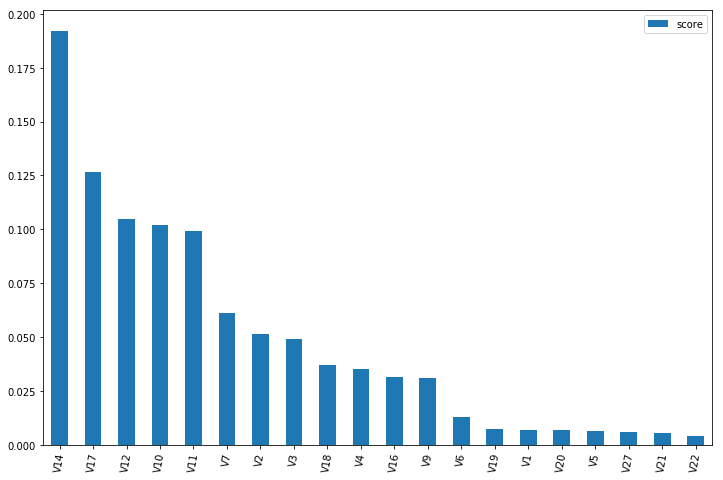

In [28]:
feat = pd.DataFrame(index=X_train.keys(), data=rand_for_class.feature_importances_, columns=['score'])
feat = feat.sort_values(by='score', ascending=False)

feat[:20].plot(kind='bar', rot=80)

***

Observamos que los modelos de **Regresión Logística**, **Árbol de decisión** y **Random Forest** nos dan resultados parecidos. No obstante, como ya hemos dicho, **Random Forest** provee una mejora sobre los árboles de decisión para reducir la varianza, por lo que en los próximos modelos, en los que se ha usado **Resampling**, vamos a usar **Random Forest**.

# 8. Resampling <a class="anchor" id="resampling"></a>

Como ya se ha comentado, la variable a predecir en este conjunto de datos está desbalanceada, habiendo muy pocos casos en los que de verdad haya habido fraude. Por este motivo, una buena estrategia es rebalancear el conjunto de datos, y para ello vamos a usar 3 técnicas [[1](https://medium.com/bluekiri/dealing-with-highly-imbalanced-classes-7e36330250bc)]:

* **Downsampling**: todas las observaciones de la clase minoritaría se mantienen, mientras que se rebalancea la clase mayoritaria (sin reemplazo) haciendo que el número de observaciones resultantes sea igual al tamaño de la clase minoritaria.

* **Upsampling**: se duplica aleatoriamente el número de muestras de la clase minoritaria para que sea igual al número de muestras de la clase mayoritaria y así reforzar su señal.

* **Negative downsampling**: se usan diferentes tamaños de muestras, dejando igual al número de muestras de la clase minoritaria y cogiendo diferentes números de observaciones de la clase mayoritaria (sin reemplazo).

Para **Downsampling** y **Upsampling**, se ha creado un algoritmo que nos informa cuánto se han de rebalancear la clase mayoritaria y la clase minoritaria, respectivamente, para posteriormente crear el modelo definitivo a partir de estos rebalanceos. Las técnicas de rebalanceo con *SkLearn* se han extraído de [[2](https://elitedatascience.com/imbalanced-classes)].

Además, se ha tenido en cuenta la métrica **Log Loss** (*Logarithmic loss*) para cuantificar el *accuracy* de un clasificador penalizando las clasificaciones falsas. Minimizar el *Log Loss* es equivalente a maximizar el *accuracy* del clasificador. Un clasificador perfecto tendrá un *Log Loss* de cero. La expresión de *Log Loss* para un conjunto de datos de dos clases es [[3](http://www.exegetic.biz/blog/2015/12/making-sense-logarithmic-loss/)]:

$$ - \frac{1}{N} \sum_{i=1}^{N}{[y_i \log{p_i} + (1 - y_i) \log{(1 - p_i)}]} $$

In [29]:
from sklearn.utils import resample

### 8.1 Downsampling <a class="anchor" id="downsampling"></a>

Primero comprobamos cómo ha de ser el resampling de la clase mayoritaria:

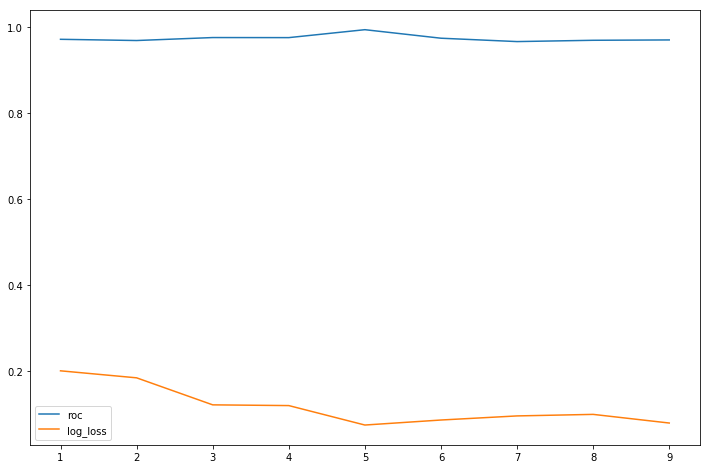

In [32]:
df_majority = df[df.Class == 0]
df_minority = df[df.Class == 1]

roc = []
logloss = []

for i in range(1, 10):
    df_majority_downsampled = resample(df_majority, 
                                     replace = False,
                                     n_samples = len(df_minority) * i,
                                     random_state = 123)

    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    df_X = df_downsampled.copy()
    df_y = df_X['Class']
    del df_X['Class']

    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, 
                                                        test_size = 0.25, 
                                                        random_state = 1234)
    
    scaler = StandardScaler()
    rand_for_class = RandomForestClassifier()

    scaler_step = ('scaler', scaler)
    rand_for_class_step = ('rand_for_class', rand_for_class)
    steps = [scaler_step, rand_for_class_step]
    pipe = Pipeline(steps)

    tuned_parameters = {'rand_for_class__n_estimators': range(15, 30, 2),
                        'rand_for_class__max_features': ['sqrt', 'auto'],
                        'rand_for_class__max_depth': range(8, 25)}

    kfold = StratifiedKFold(n_splits = 5)

    gs_rand_for_class = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
    gs_rand_for_class.fit(X_train, y_train)

    y_pred_rand_for_class = gs_rand_for_class.predict_proba(X_test)

    roc.append(roc_auc_score(y_true=y_test, y_score=y_pred_rand_for_class[:,1]))
    logloss.append(log_loss(y_test, y_pred_rand_for_class[:,1]))

plt.plot(range(1, 10), roc, label='roc')
plt.plot(range(1, 10), logloss, label='log_loss')
plt.legend(loc='best')
plt.show()

<br>
Observamos de la anterior gráfica que con la clase mayoritaria siendo 5 veces más grande que la clase minoritaria, obtendremos una **Curva ROC** mayor y un **Log Loss** menor. Por esta razón, a continuación generamos un modelo cuyo resampling tenga estas características:

In [30]:
df_majority = df[df.Class == 0]
df_minority = df[df.Class == 1]

df_majority_downsampled = resample(df_majority, 
                                 replace = False,
                                 n_samples = len(df_minority) * 5,
                                 random_state = 123)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df_X = df_downsampled.copy()
df_y = df_X['Class']
del df_X['Class']

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, 
                                                    test_size = 0.25, 
                                                    random_state = 1234)
    
scaler = StandardScaler()
rand_for_class = RandomForestClassifier()

scaler_step = ('scaler', scaler)
rand_for_class_step = ('rand_for_class', rand_for_class)
steps = [scaler_step, rand_for_class_step]
pipe = Pipeline(steps)

tuned_parameters = {'rand_for_class__n_estimators': range(15, 30, 2),
                    'rand_for_class__max_features': ['sqrt', 'auto'],
                    'rand_for_class__max_depth': range(8, 25)}

kfold = StratifiedKFold(n_splits = 5)

gs_rand_for_class = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_rand_for_class.fit(X_train, y_train)

y_pred_rand_for_class = gs_rand_for_class.predict_proba(X_test)

print("Best params: ", gs_rand_for_class.best_params_)
print('\n')
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_rand_for_class[:,1]))
print('\n')
print("Log loss:", log_loss(y_test, y_pred_rand_for_class[:,1]))

Best params:  {'rand_for_class__n_estimators': 25, 'rand_for_class__max_depth': 17, 'rand_for_class__max_features': 'sqrt'}


ROC Curve: 1.00


Log loss: 0.06771809178


***

### 8.2 Upsampling <a class="anchor" id="upsampling"></a>

Primero comprobamos cómo ha de ser el resampling de la clase minoritaria:

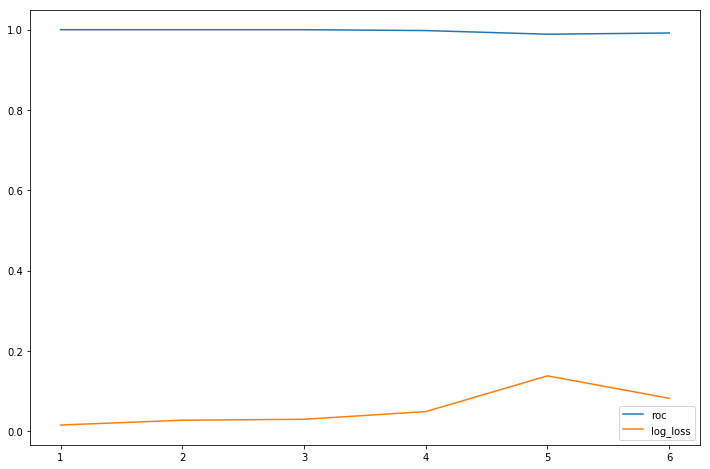

In [34]:
df_majority = df[df.Class == 0]
df_minority = df[df.Class == 1]

roc = []
logloss = []

for i in range(1, 7):
    df_minority_upsampled = resample(df_minority, 
                                     replace = True,
                                     n_samples = round(len(df_majority) / i),
                                     random_state = 123)

    df_upsampled = pd.concat([df_minority_upsampled, df_majority])

    df_X = df_upsampled.copy()
    df_y = df_X['Class']
    del df_X['Class']

    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, 
                                                        test_size = 0.25, 
                                                        random_state = 1234)

    scaler = StandardScaler()
    rand_for_class = RandomForestClassifier()

    scaler_step = ('scaler', scaler)
    rand_for_class_step = ('rand_for_class', rand_for_class)
    steps = [scaler_step, rand_for_class_step]
    pipe = Pipeline(steps)

    tuned_parameters = {'rand_for_class__n_estimators': range(15, 30, 2),
                        'rand_for_class__max_features': ['sqrt', 'auto'],
                        'rand_for_class__max_depth': range(8, 25)}
    
    kfold = StratifiedKFold(n_splits = 5)

    gs_rand_for_class = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
    gs_rand_for_class.fit(X_train, y_train)

    y_pred_rand_for_class = gs_rand_for_class.predict_proba(X_test)

    roc.append(roc_auc_score(y_true=y_test, y_score=y_pred_rand_for_class[:,1]))
    logloss.append(log_loss(y_test, y_pred_rand_for_class[:,1]))
    
plt.plot(range(1, 7), roc, label='roc')
plt.plot(range(1, 7), logloss, label='log_loss')
plt.legend(loc='best')
plt.show()

<br>
Vemos que el mejor resultado nos lo da el modelo cuyo tamaño de la clase minoritaria es igual al tamaño de la clase mayoritaria, por lo que a continuación generamos un modelo con estas características:

In [31]:
df_majority = df[df.Class == 0]
df_minority = df[df.Class == 1]

df_minority_upsampled = resample(df_minority, 
                                 replace = True,
                                 n_samples = len(df_majority),
                                 random_state = 123)

df_upsampled = pd.concat([df_minority_upsampled, df_majority])

df_X = df_upsampled.copy()
df_y = df_X['Class']
del df_X['Class']

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, 
                                                    test_size = 0.25, 
                                                    random_state = 1234)

scaler = StandardScaler()
rand_for_class = RandomForestClassifier()

scaler_step = ('scaler', scaler)
rand_for_class_step = ('rand_for_class', rand_for_class)
steps = [scaler_step, rand_for_class_step]
pipe = Pipeline(steps)

tuned_parameters = {'rand_for_class__n_estimators': range(15, 30, 2),
                    'rand_for_class__max_features': ['sqrt', 'auto'],
                    'rand_for_class__max_depth': range(8, 25)}

kfold = StratifiedKFold(n_splits = 5)

gs_rand_for_class = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_rand_for_class.fit(X_train, y_train)

y_pred_rand_for_class = gs_rand_for_class.predict_proba(X_test)

print("Best params: ", gs_rand_for_class.best_params_)
print('\n')
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_rand_for_class[:,1]))
print('\n')
print("Log loss:", log_loss(y_test, y_pred_rand_for_class[:,1]))

Best params:  {'rand_for_class__n_estimators': 19, 'rand_for_class__max_depth': 22, 'rand_for_class__max_features': 'auto'}


ROC Curve: 1.00


Log loss: 0.0165621519698


***

### 8.3 Negative downsampling <a class="anchor" id="negative-downsampling"></a>

Para este tipo de *resampling* se usa la clase **CalibratedClassifierCV** [[4](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html)] de *SkLearn*. Esta clase hace un *fit* del modelo que le pasamos por parámetro sobre el conjunto de entrenamiento, y el conjunto de prueba se usa para calibrar las clases. Posteriormente, se usa la media de las probabilidades para cada partición de la validación cruzada para la predicción.

In [32]:
from sklearn.calibration import CalibratedClassifierCV

In [33]:
df_X = df.copy()
df_y = df_X['Class']
del df_X['Class']

X_train, X_test, y_train, y_test = train_test_split(df_X,
                                                    df_y, 
                                                    test_size=0.25,
                                                    random_state=1234)

rand_for_class = RandomForestClassifier(max_depth = 14, 
                                        max_features = 'sqrt', 
                                        n_estimators = 24)

# Isotonic calibration
scaler = StandardScaler()
cal_class_cv_isotonic = CalibratedClassifierCV(rand_for_class, cv=5, method='isotonic')

scaler_step = ('scaler', scaler)
cal_class_cv_isotonic_step = ('cal_class_cv_isotonic', cal_class_cv_isotonic)
steps = [scaler_step, cal_class_cv_isotonic_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)
y_pred_cal_class_cv_isotonic = pipe.predict_proba(X_test)


# Sigmoid calibration
scaler = StandardScaler()
cal_class_cv_sigmoid = CalibratedClassifierCV(rand_for_class, cv=5, method='sigmoid')

scaler_step = ('scaler', scaler)
cal_class_cv_sigmoid_step = ('cal_class_cv_sigmoid', cal_class_cv_sigmoid)
steps = [scaler_step, cal_class_cv_sigmoid_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)
y_pred_cal_class_cv_sigmoid = pipe.predict_proba(X_test)


# Results
print("With isotonic calibration: %1.3f" % brier_score_loss(y_test, y_pred_cal_class_cv_isotonic[:,1]))
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_cal_class_cv_isotonic[:,1]))
print("Log loss:", log_loss(y_test, y_pred_cal_class_cv_isotonic[:,1]))

print("\n")

print("With sigmoid calibration: %1.3f" % brier_score_loss(y_test, y_pred_cal_class_cv_sigmoid[:,1]))
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_cal_class_cv_sigmoid[:,1]))
print("Log loss:", log_loss(y_test, y_pred_cal_class_cv_sigmoid[:,1]))

With isotonic calibration: 0.009
ROC Curve: 0.97
Log loss: 0.0484200263191


With sigmoid calibration: 0.009
ROC Curve: 0.96
Log loss: 0.0504632885614


# 9. Verificación del test final con Upsampling (Modelo 1) <a class="anchor" id="verificacion-1"></a>

In [34]:
df_test = pd.read_csv('data/fraud/creditcard_test.csv', index_col=0, sep=',')
df_test.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,312.0,-0.987858,0.475771,1.672622,1.178044,0.730282,-0.403391,0.308014,0.254682,-1.045606,0.155401,1.793725,0.702015,-0.319470,0.685310,0.877367,-0.447056,0.096462,-0.395179,0.795532,0.392656,-0.319192,-1.132128,0.233566,0.140309,0.072813,-0.637665,0.231877,0.062719,33.26
1,466.0,-1.064559,0.432452,0.128327,-2.019741,0.014434,-0.487552,0.293956,0.087702,-0.473573,1.350467,0.014346,-0.920272,-1.211440,-0.203151,-1.440059,1.137245,-0.224755,-0.695313,0.713191,0.398423,0.112732,0.667153,-0.092997,-0.533060,0.003726,-0.271817,0.689156,0.480554,20.00
2,483.0,-0.792724,0.946688,2.245149,1.167398,-0.625405,-0.449979,0.157625,0.015379,0.269781,-0.021304,-0.375567,0.478018,0.287826,-0.473544,0.127464,-0.680594,0.223911,0.014717,0.365767,0.114467,0.223032,0.926665,-0.170298,0.972432,-0.115298,-0.229900,0.156610,0.252310,4.42
3,742.0,-1.638212,0.395044,1.487210,-0.536682,1.691993,-0.610509,0.479928,-0.209453,-0.161525,-0.358540,-0.468911,0.046148,0.792222,-0.882591,0.878150,0.432647,-0.360270,-0.577628,-0.748662,-0.118687,-0.405072,-0.800599,-0.501077,-0.654136,0.249438,0.058013,-0.026457,-0.112420,11.98
4,945.0,0.904759,-0.518302,0.398305,0.495653,-0.834514,-0.642216,0.044820,-0.043259,0.223597,-0.119216,1.299905,0.849929,-0.691546,0.411388,-0.333285,0.082616,-0.214906,-0.157369,0.400149,0.175592,-0.096473,-0.576288,-0.051439,0.572083,0.192744,0.400686,-0.079651,0.027963,158.00


In [35]:
# Upsampling
df_majority = df[df.Class == 0]
df_minority = df[df.Class == 1]

df_minority_upsampled = resample(df_minority, 
                                 replace = True,
                                 n_samples = len(df_majority),
                                 random_state = 123)

df_upsampled = pd.concat([df_minority_upsampled, df_majority])

X_train = df_upsampled.copy()
y_train = X_train['Class']
del X_train['Class']


# Training the model
scaler = StandardScaler()
rand_for_class = RandomForestClassifier(max_depth = 22, 
                                        max_features = 'auto',
                                        n_estimators = 23)


scaler_step = ('scaler', scaler)
rand_for_class_step = ('rand_for_class', rand_for_class)
steps = [scaler_step, rand_for_class_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)
y_pred_final = pipe.predict_proba(df_test)


# Predicting test
predict_class = y_pred_final[:, 1] > 0.5
prob_class_1 = y_pred_final[:, 1]

df_final = pd.DataFrame({'probabilidad_clase_1': prob_class_1, 'clase_predicha': predict_class})
df_final.index.name = 'IdObservación'
df_final.head()

,clase_predicha,probabilidad_clase_1
IdObservación,,
0,False,0.000000
1,False,0.043478
2,False,0.000000
3,False,0.043478
4,False,0.000000


In [36]:
df_final.to_csv('JMM_test_1.csv', sep=',')

***

# 10. Verificación del test final con Calibrating (Modelo 2) <a class="anchor" id="verificacion-2"></a>

In [37]:
df_test = pd.read_csv('data/fraud/creditcard_test.csv', index_col=0, sep=',')
df_test.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,312.0,-0.987858,0.475771,1.672622,1.178044,0.730282,-0.403391,0.308014,0.254682,-1.045606,0.155401,1.793725,0.702015,-0.319470,0.685310,0.877367,-0.447056,0.096462,-0.395179,0.795532,0.392656,-0.319192,-1.132128,0.233566,0.140309,0.072813,-0.637665,0.231877,0.062719,33.26
1,466.0,-1.064559,0.432452,0.128327,-2.019741,0.014434,-0.487552,0.293956,0.087702,-0.473573,1.350467,0.014346,-0.920272,-1.211440,-0.203151,-1.440059,1.137245,-0.224755,-0.695313,0.713191,0.398423,0.112732,0.667153,-0.092997,-0.533060,0.003726,-0.271817,0.689156,0.480554,20.00
2,483.0,-0.792724,0.946688,2.245149,1.167398,-0.625405,-0.449979,0.157625,0.015379,0.269781,-0.021304,-0.375567,0.478018,0.287826,-0.473544,0.127464,-0.680594,0.223911,0.014717,0.365767,0.114467,0.223032,0.926665,-0.170298,0.972432,-0.115298,-0.229900,0.156610,0.252310,4.42
3,742.0,-1.638212,0.395044,1.487210,-0.536682,1.691993,-0.610509,0.479928,-0.209453,-0.161525,-0.358540,-0.468911,0.046148,0.792222,-0.882591,0.878150,0.432647,-0.360270,-0.577628,-0.748662,-0.118687,-0.405072,-0.800599,-0.501077,-0.654136,0.249438,0.058013,-0.026457,-0.112420,11.98
4,945.0,0.904759,-0.518302,0.398305,0.495653,-0.834514,-0.642216,0.044820,-0.043259,0.223597,-0.119216,1.299905,0.849929,-0.691546,0.411388,-0.333285,0.082616,-0.214906,-0.157369,0.400149,0.175592,-0.096473,-0.576288,-0.051439,0.572083,0.192744,0.400686,-0.079651,0.027963,158.00


In [38]:
X_train = df.copy()
y_train = X_train['Class']
del X_train['Class']

# Training the model
rand_for_class = RandomForestClassifier(max_depth = 23, 
                                        max_features = 'sqrt', 
                                        n_estimators = 25)

scaler = StandardScaler()
cal_class_cv_sigmoid = CalibratedClassifierCV(rand_for_class, cv=5, method='sigmoid')

scaler_step = ('scaler', scaler)
cal_class_cv_sigmoid_step = ('cal_class_cv_sigmoid', cal_class_cv_sigmoid)
steps = [scaler_step, cal_class_cv_sigmoid_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)
y_pred_final = pipe.predict_proba(df_test)


# Predicting test
predict_class = y_pred_final[:, 1] > 0.5
prob_class_1 = y_pred_final[:, 1]

df_final = pd.DataFrame({'probabilidad_clase_1': prob_class_1, 'clase_predicha': predict_class})
df_final.index.name = 'IdObservación'
df_final.head()

,clase_predicha,probabilidad_clase_1
IdObservación,,
0,False,0.007679
1,False,0.011481
2,False,0.007679
3,False,0.007679
4,False,0.005989


In [39]:
df_final.to_csv('JMM_test_2.csv', sep=',')

# 11. Bibliografía <a class="anchor" id="bibliografia"></a>

[1] Dealing with Highly Imbalanced Classes in Classification Algorithms. https://medium.com/bluekiri/dealing-with-highly-imbalanced-classes-7e36330250bc

[2] How to Handle Imbalanced Classes in Machine Learning. https://elitedatascience.com/imbalanced-classes

[3] Making Sense of Logarithmic Loss. http://www.exegetic.biz/blog/2015/12/making-sense-logarithmic-loss/

[4] CalibratedClassifierCV. http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html